# Imports

In [2]:
# Plotting
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Math + stats
import numpy as np
import pandas as pd
from scipy.stats import binom

# Logistics
from os.path import sep
from tqdm import tqdm
import time

# Local modules
import nested_simulation_functions

# Enable re-load of local modules every time they are called
%load_ext autoreload
%autoreload 2
%aimport numpy 
%aimport pandas

# Parameters

In [33]:
# Structural parameters
students_per_school = 20  # Number of students in a school (> 0)
n_schools_per_L1 = 10 # Number of schools in each L1 unit (> 0)
n_L1s_per_L2 = 10 # Number of L1s in each L2 unit (L2 visits all L1s) (> 0)
n_L2s = 1 # Number of L2s (> 0)
L1_retest_percentage = 25 # Percentage of students in a school retested by L1 (between 0 to 100)
L2_retest_percentage_schools = 100 # Percentage of schools visited by L2 in a given L1 unit (between 0 to 100)
L2_retest_percentage_students = 20 # Percentage of students retested by L2 (from eligible students, i.e. 
                                        # those retested by L1) (between 0 to 100)

# Subjects parameters - mean and standard deviation of scores, and granularity, i.e. the number of possible 
                                            # unique scores for a student
# Mean should be between 0 - 100
# Standard deviation can be any number > 0, larger value will give more spread across students
# Granularity should be between 2 (binary - pass/fail) and 101 (marks as percentage)
subjects = ['Maths', 'English', 'Tamil']
subjects_params = {
    "Maths": {"mean": 60, "std_dev": 30, "granularity": 101},
    "English": {"mean": 70, "std_dev": 20, "granularity": 101},
    "Tamil": {"mean": 55, "std_dev": 20, "granularity": 101}
}
passing_marks = {"Maths": 50, "English": 90, "Tamil": 90}  # Passing marks for each subject (between 0 and 100)

# Distortion parameters (common)
measurement_error_mean = 0 # Keep at 0 since we are assuming measurement error centered around zero
                           # But technically can be any positive or negative number.
measurement_error_std_dev = 0.5 # Any number > 0. Larger will give more noise

# L0 distortion parameters
minimum_marks = {'Maths': 50, 'English': 40, 'Tamil': 40} # Between 0 and passing marks for the subject.
                                                          # Higher --> more integrity distortion
delta = 20 # Marks below passing mark at which L0 starts giving passing marks (between 0 and passing marks)

# L1 distortion parameters
collusion_index = 0  # Collusion index for L1 distortion - between 0 and 1. 0 means no L1 integrity distortion;
                       # 1 means L1 integrity distortion is as much as L0. 
moderation_index_L1 = 0 # Moderation for L1 distortion - between -100 and 100

# L2 distortion parameters
moderation_index_L2 = 0  # Moderation index for L2 distortion - between -100 and 100

# Real scores

Text(0, 0.5, 'Number of students')

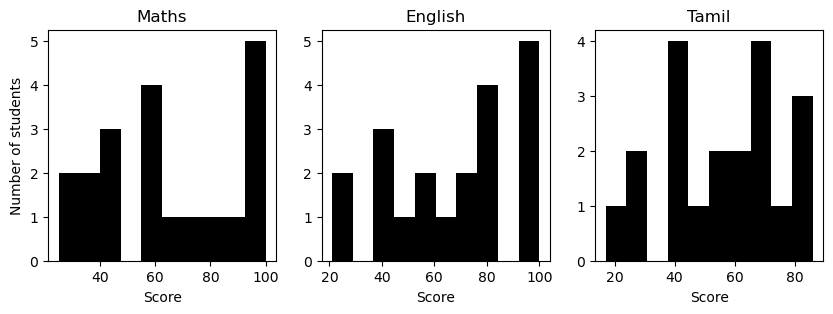

In [82]:
subjects = list(subjects_params.keys())
n_subjects = len(subjects)    

# Generate real scores
real_scores = nested_simulation_functions.generate_real_scores(students_per_school, subjects_params)

fig, ax = plt.subplots(nrows = 1, ncols = n_subjects, figsize = [10, 3])
for i in range(n_subjects):
    ax[i].hist(real_scores[subjects[i]], color = 'k')
    ax[i].set_xlabel('Score')
    ax[i].set_title(subjects[i])
    
ax[0].set_ylabel('Number of students')

# L0 scores (single school)

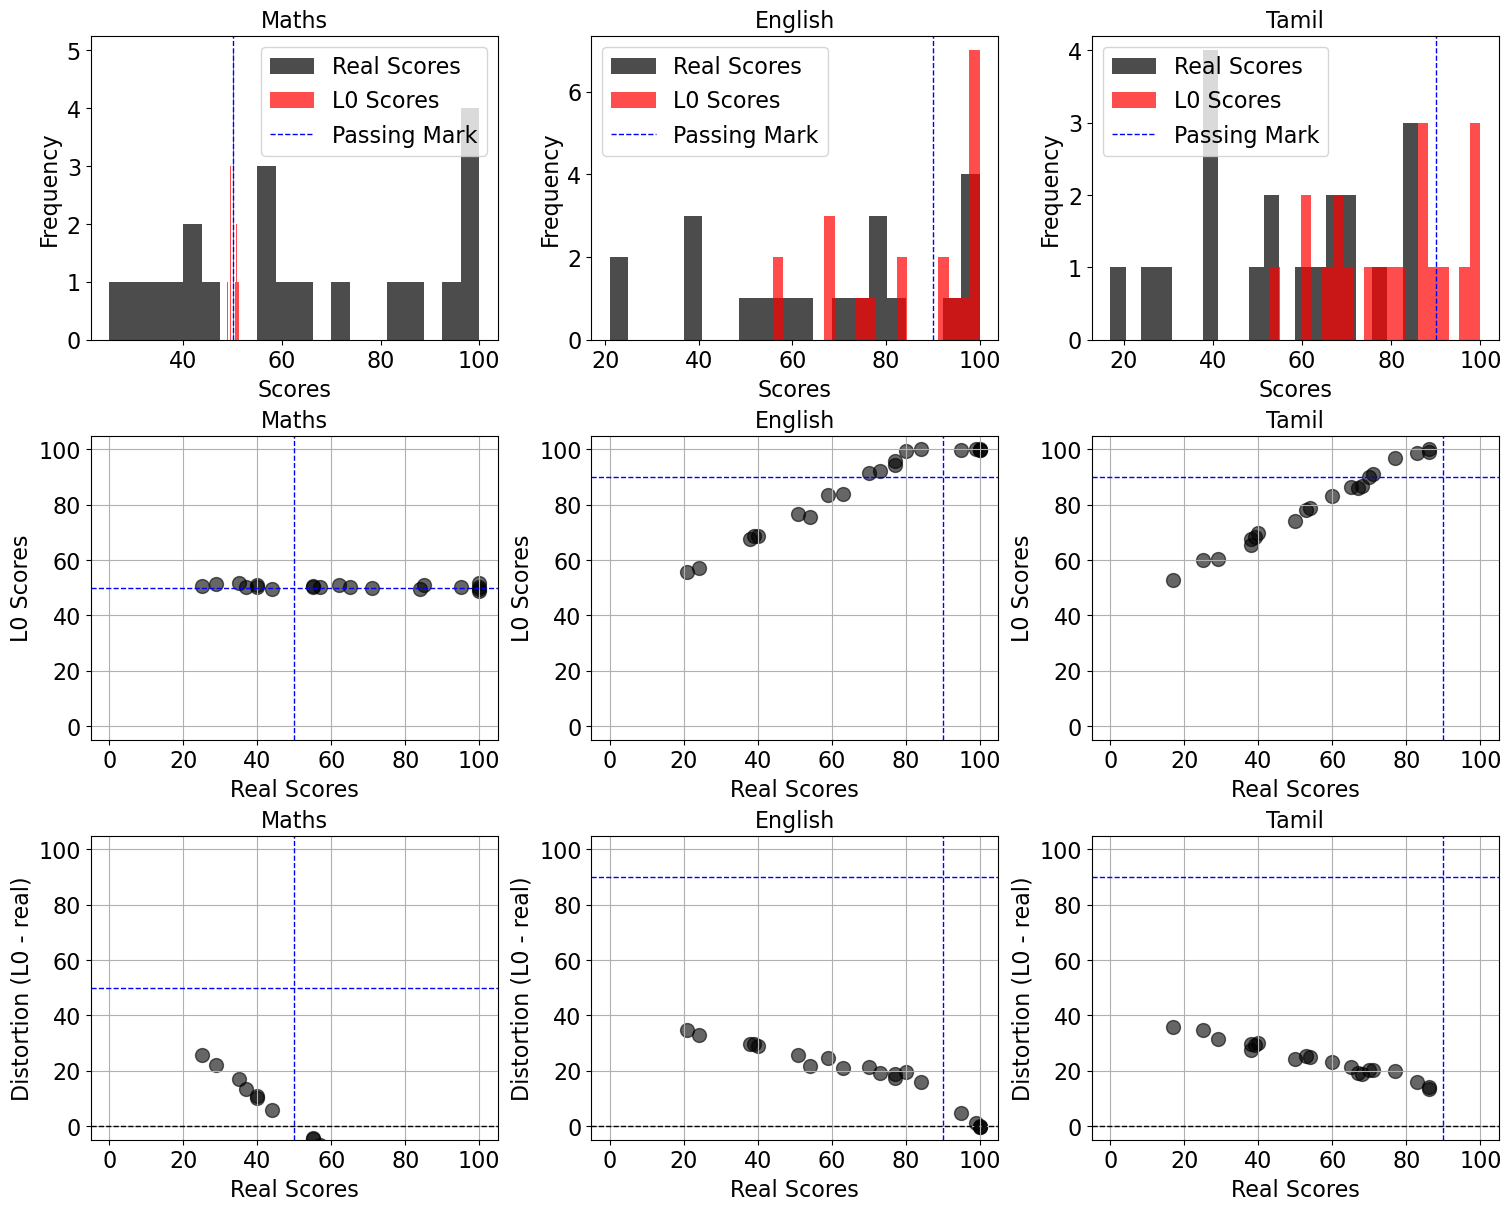

In [84]:
# Apply L0 distortions
L0_scores = nested_simulation_functions.apply_distortion_L0(real_scores, passing_marks, minimum_marks,
                                                            delta,
                                                       measurement_error_mean = measurement_error_mean,
                                                    measurement_error_std_dev = measurement_error_std_dev)

# General plot settings
font_size = 16  # Font size for titles, labels, and ticks
scatter_point_size = 100  # Size of points in scatter plots
hist_color_real = "black"  # Color for real scores in histograms
hist_color_L0 = "red"  # Color for L0 scores in histograms
scatter_color = "black"  # Color for scatter plots
pass_mark_color = "blue" # Color for dashed vertical line indicating passing marks
axis_limits = [-5, 105]

# Create subplots for histograms
fig, axes = plt.subplots(3, len(subjects_params), figsize=(15, 12), constrained_layout=True)

# Plot histograms for real scores and L0 scores for each subject
for idx, subject in enumerate(subjects_params.keys()):
    
    passing_mark = passing_marks[subject]

    # Histogram for real scores
    axes[0, idx].hist(real_scores[subject], bins=20, alpha=0.7, label="Real Scores", color=hist_color_real)
    axes[0, idx].hist(L0_scores[subject], bins=20, alpha=0.7, label="L0 Scores", color=hist_color_L0)
    axes[0, idx].axvline(passing_mark, color = pass_mark_color, linestyle="--", linewidth=1, label="Passing Mark")
    axes[0, idx].set_title(subject, fontsize=font_size)
    axes[0, idx].set_xlabel("Scores", fontsize=font_size)
    axes[0, idx].set_ylabel("Frequency", fontsize=font_size)
    axes[0, idx].tick_params(axis="both", labelsize=font_size)
    axes[0, idx].legend(fontsize=font_size)

    # Scatter plot: L0 scores vs Real scores
    axes[1, idx].scatter(real_scores[subject], L0_scores[subject], alpha=0.6, color=scatter_color, s=scatter_point_size)
    axes[1, idx].axvline(passing_mark, color="blue", linestyle="--", linewidth=1, label="Passing Mark")
    axes[1, idx].axhline(passing_mark, color="blue", linestyle="--", linewidth=1)
    axes[1, idx].set_title(subject, fontsize=font_size)
    axes[1, idx].set_xlabel("Real Scores", fontsize=font_size)
    axes[1, idx].set_ylabel("L0 Scores", fontsize=font_size)
    axes[1, idx].tick_params(axis="both", labelsize=font_size)
    axes[1, idx].set_xlim(axis_limits)
    axes[1, idx].set_ylim(axis_limits)
    axes[1, idx].grid(True)

    distortion = L0_scores[subject] - real_scores[subject]
    axes[2, idx].scatter(real_scores[subject], distortion, alpha=0.6, color=scatter_color, s=scatter_point_size)
    axes[2, idx].axhline(0, color="black", linestyle="--", linewidth=1)
    axes[2, idx].axvline(passing_mark, color="blue", linestyle="--", linewidth=1, label="Passing Mark")
    axes[2, idx].axhline(passing_mark, color="blue", linestyle="--", linewidth=1)
    axes[2, idx].set_title(subject, fontsize=font_size)
    axes[2, idx].set_xlabel("Real Scores", fontsize=font_size)
    axes[2, idx].set_ylabel("Distortion (L0 - real)", fontsize=font_size)
    axes[2, idx].tick_params(axis="both", labelsize=font_size)
    axes[2, idx].set_xlim(axis_limits)
    axes[2, idx].set_ylim(axis_limits)
    axes[2, idx].grid(True)

plt.show()

# L1 scores (single school, all students)

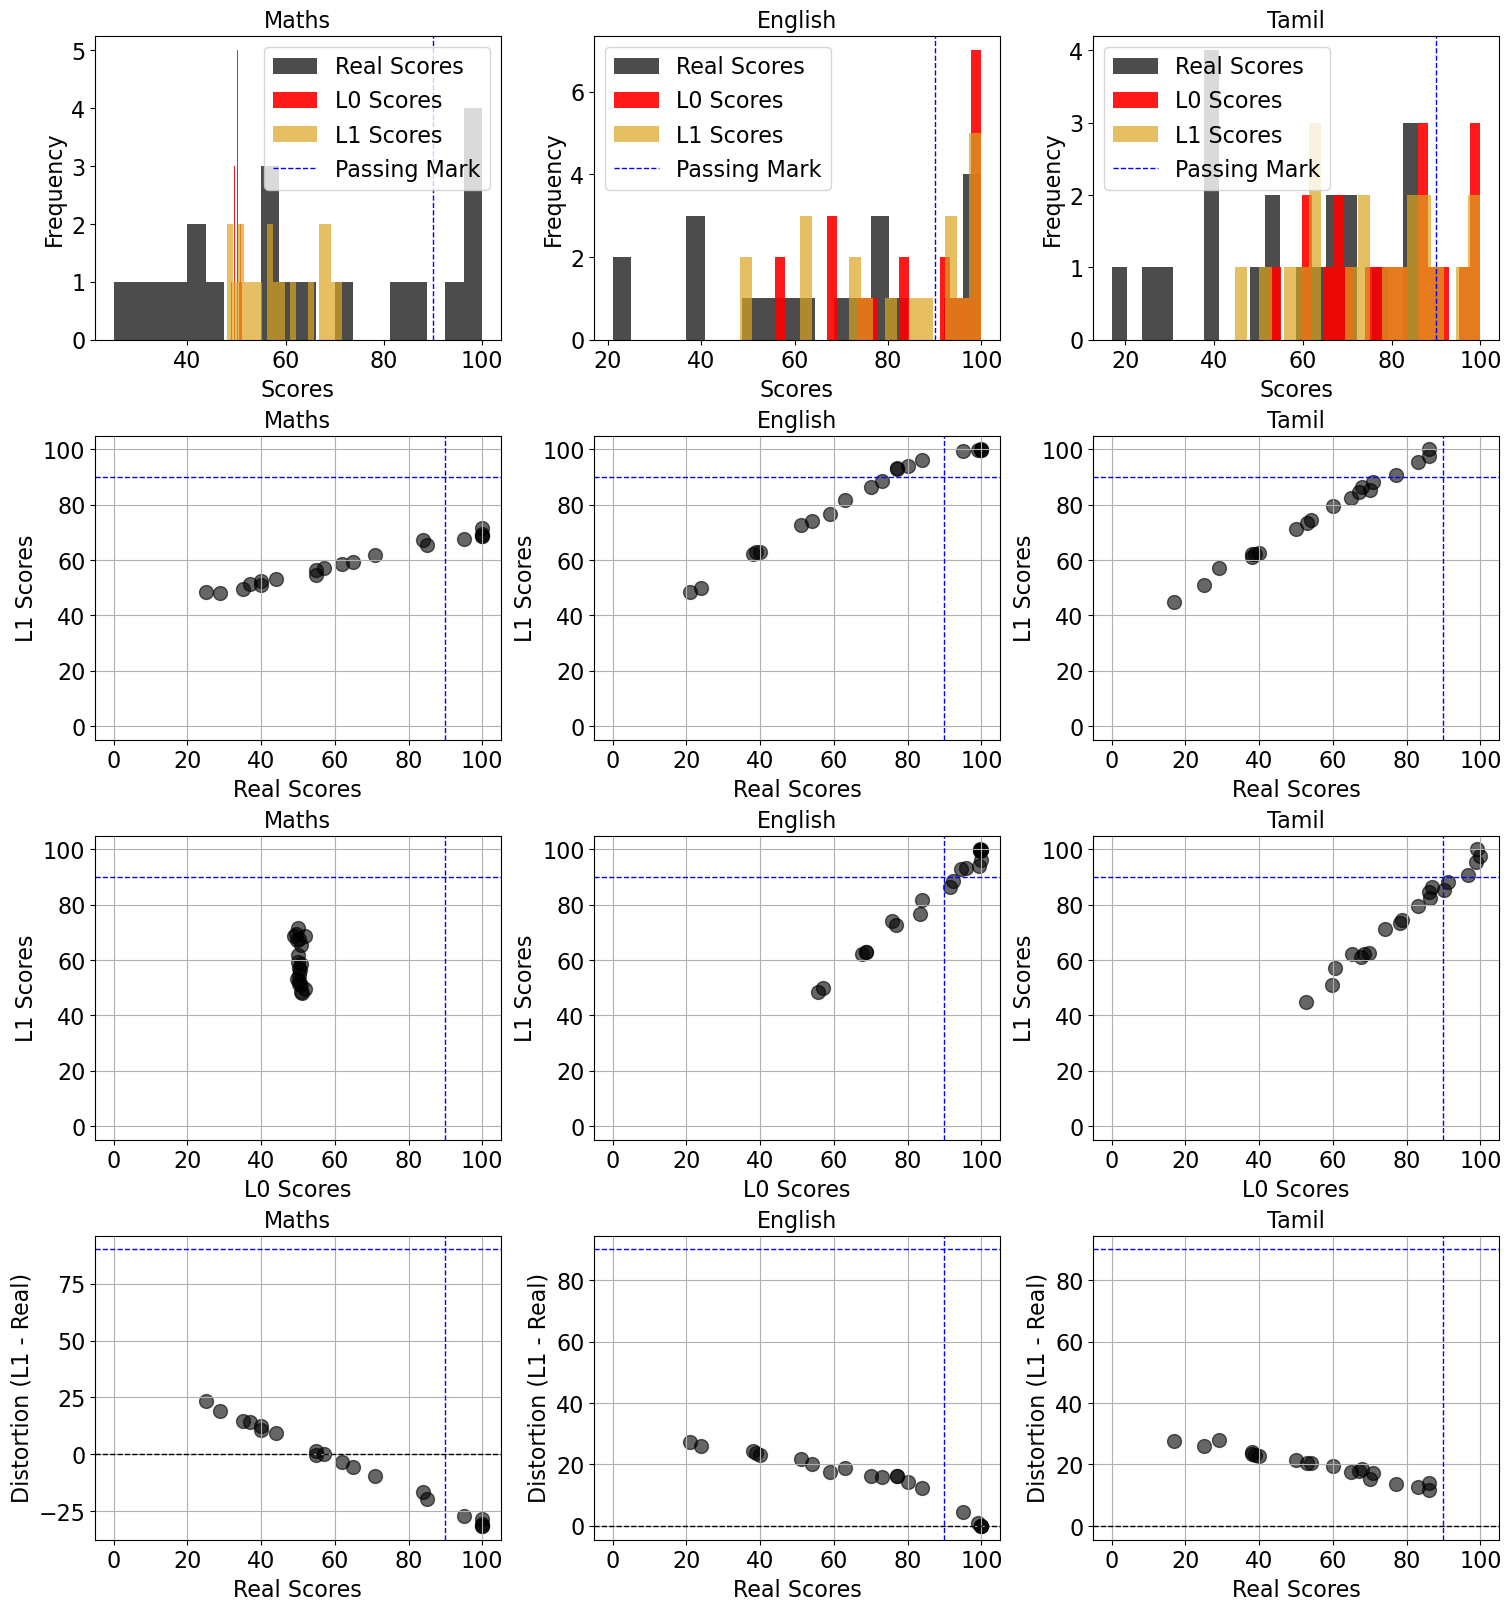

In [86]:
# Apply L1 distortions
L1_scores = nested_simulation_functions.apply_distortion_L1(real_scores, passing_marks, minimum_marks,
                                                            delta, collusion_index,
                                                            measurement_error_mean = measurement_error_mean, 
                                                        measurement_error_std_dev = measurement_error_std_dev,
                                                           moderation_index_L1 = moderation_index_L1)

# General plot settings
font_size = 16  # Font size for titles, labels, and ticks
scatter_point_size = 100  # Size of points in scatter plots
hist_color_real = "black"  # Color for real scores in histograms
hist_color_L0 = "red"  # Color for L0 scores in histograms
hist_color_L1 = "goldenrod"  # Color for L1 scores in histograms
scatter_color = "black"  # Color for scatter plots
pass_mark_color = "blue" # Color for dashed line indicating passing mark
axis_limits = [-5, 105]  # Axis limits for scatter plots

# Create subplots for histograms
fig, axes = plt.subplots(4, len(subjects_params), figsize=(15, 16), constrained_layout=True)

# Plot histograms for real scores, L0 scores, and L1 scores for each subject
for idx, subject in enumerate(subjects_params.keys()):
    # Histogram for real scores
    axes[0, idx].hist(real_scores[subject], bins=20, alpha=0.7, label="Real Scores", color=hist_color_real)
    axes[0, idx].hist(L0_scores[subject], bins=20, alpha=0.9, label="L0 Scores", color=hist_color_L0)
    axes[0, idx].hist(L1_scores[subject], bins=20, alpha=0.7, label="L1 Scores", color=hist_color_L1)
    axes[0, idx].axvline(passing_mark, color = pass_mark_color, linestyle="--", linewidth=1, label="Passing Mark")
    axes[0, idx].set_title(subject, fontsize=font_size)
    axes[0, idx].set_xlabel("Scores", fontsize=font_size)
    axes[0, idx].set_ylabel("Frequency", fontsize=font_size)
    axes[0, idx].tick_params(axis="both", labelsize=font_size)
    axes[0, idx].legend(fontsize=font_size)

    # Scatter plot: L1 scores vs Real scores
    axes[1, idx].scatter(real_scores[subject], L1_scores[subject], alpha=0.6, color=scatter_color, s=scatter_point_size)
    axes[1, idx].axvline(passing_mark, color="blue", linestyle="--", linewidth=1, label="Passing Mark")
    axes[1, idx].axhline(passing_mark, color="blue", linestyle="--", linewidth=1)
    axes[1, idx].set_title(subject, fontsize=font_size)
    axes[1, idx].set_xlabel("Real Scores", fontsize=font_size)
    axes[1, idx].set_ylabel("L1 Scores", fontsize=font_size)
    axes[1, idx].tick_params(axis="both", labelsize=font_size)
    axes[1, idx].grid(True)
    axes[1, idx].set_xlim(axis_limits)
    axes[1, idx].set_ylim(axis_limits)

    # Scatter plot: L1 scores vs L0 scores
    axes[2, idx].scatter(L0_scores[subject], L1_scores[subject], alpha=0.6, color=scatter_color, s=scatter_point_size)
    axes[2, idx].axvline(passing_mark, color="blue", linestyle="--", linewidth=1, label="Passing Mark")
    axes[2, idx].axhline(passing_mark, color="blue", linestyle="--", linewidth=1)
    axes[2, idx].set_title(subject, fontsize=font_size)
    axes[2, idx].set_xlabel("L0 Scores", fontsize=font_size)
    axes[2, idx].set_ylabel("L1 Scores", fontsize=font_size)
    axes[2, idx].tick_params(axis="both", labelsize=font_size)
    axes[2, idx].grid(True)
    axes[2, idx].set_xlim(axis_limits)
    axes[2, idx].set_ylim(axis_limits)

    # Plot distortion (L1 score - Real score) vs Real scores for each subject
    distortion = L1_scores[subject] - real_scores[subject]
    axes[3, idx].scatter(real_scores[subject], distortion, alpha=0.6, color=scatter_color, s=scatter_point_size)
    axes[3, idx].axhline(0, color="black", linestyle="--", linewidth=1)
    axes[3, idx].axvline(passing_mark, color="blue", linestyle="--", linewidth=1, label="Passing Mark")
    axes[3, idx].axhline(passing_mark, color="blue", linestyle="--", linewidth=1)
    axes[3, idx].set_title(subject, fontsize=font_size)
    axes[3, idx].set_xlabel("Real Scores", fontsize=font_size)
    axes[3, idx].set_ylabel("Distortion (L1 - Real)", fontsize=font_size)
    axes[3, idx].tick_params(axis="both", labelsize=font_size)
    axes[3, idx].grid(True)
    axes[3, idx].set_xlim(axis_limits)

plt.show()

# L2 scores (single school, all students)

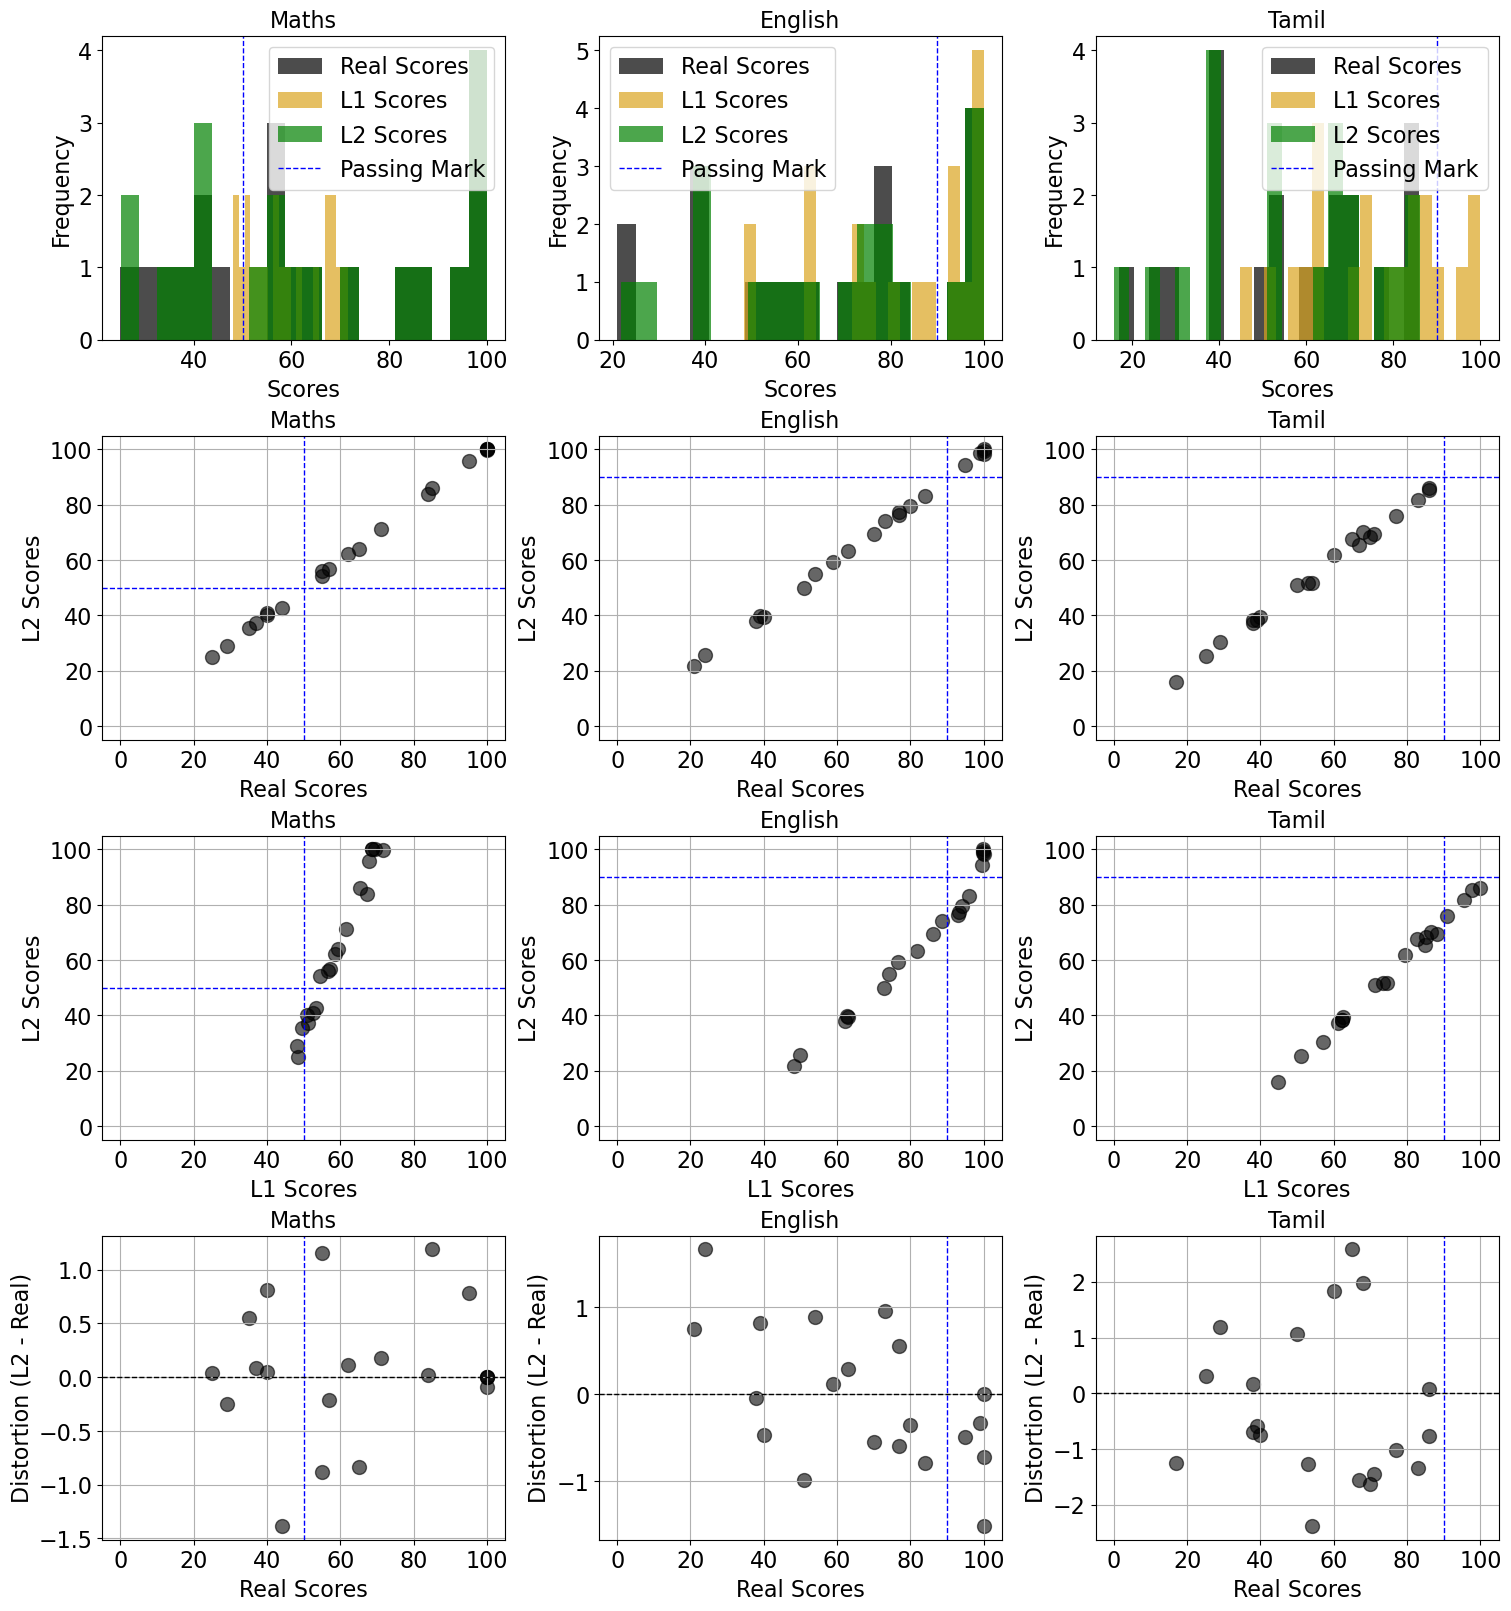

In [87]:
# Apply L2 distortions
L2_scores = nested_simulation_functions.apply_distortion_L2(real_scores, 
                                                            measurement_error_mean = measurement_error_mean, 
                                                            measurement_error_std_dev = measurement_error_std_dev, 
                                                            moderation_index_L2 = moderation_index_L2)

# General plot settings
font_size = 16  # Font size for titles, labels, and ticks
scatter_point_size = 100  # Size of points in scatter plots
hist_color_real = "black"  # Color for real scores in histograms
hist_color_L1 = "goldenrod"  # Color for L1 scores in histograms
hist_color_L2 = "green"  # Color for L2 scores in histograms
scatter_color = "black"  # Color for scatter plots
axis_limits = [-5, 105]  # Axis limits for scatter plots

# Create subplots for histograms
fig, axes = plt.subplots(4, len(subjects_params), figsize=(15, 16), constrained_layout=True)

# Plot histograms for real scores, L1 scores, and L2 scores for each subject
for idx, subject in enumerate(subjects_params.keys()):
    passing_mark = passing_marks[subject]

    # Histogram for real scores
    axes[0, idx].hist(real_scores[subject], bins=20, alpha=0.7, label="Real Scores", color=hist_color_real)
    axes[0, idx].hist(L1_scores[subject], bins=20, alpha=0.7, label="L1 Scores", color=hist_color_L1)
    axes[0, idx].hist(L2_scores[subject], bins=20, alpha=0.7, label="L2 Scores", color=hist_color_L2)
    axes[0, idx].axvline(passing_mark, color="blue", linestyle="--", linewidth=1, label="Passing Mark")
    axes[0, idx].set_title(subject, fontsize=font_size)
    axes[0, idx].set_xlabel("Scores", fontsize=font_size)
    axes[0, idx].set_ylabel("Frequency", fontsize=font_size)
    axes[0, idx].tick_params(axis="both", labelsize=font_size)
    axes[0, idx].legend(fontsize=font_size)

    # Scatter plot: L2 scores vs Real scores
    axes[1, idx].scatter(real_scores[subject], L2_scores[subject], alpha=0.6, color=scatter_color, s=scatter_point_size)
    axes[1, idx].axvline(passing_mark, color="blue", linestyle="--", linewidth=1, label="Passing Mark")
    axes[1, idx].axhline(passing_mark, color="blue", linestyle="--", linewidth=1)
    axes[1, idx].set_title(subject, fontsize=font_size)
    axes[1, idx].set_xlabel("Real Scores", fontsize=font_size)
    axes[1, idx].set_ylabel("L2 Scores", fontsize=font_size)
    axes[1, idx].tick_params(axis="both", labelsize=font_size)
    axes[1, idx].grid(True)
    axes[1, idx].set_xlim(axis_limits)
    axes[1, idx].set_ylim(axis_limits)

    # Scatter plot: L2 scores vs L1 scores
    axes[2, idx].scatter(L1_scores[subject], L2_scores[subject], alpha=0.6, color=scatter_color, s=scatter_point_size)
    axes[2, idx].axvline(passing_mark, color="blue", linestyle="--", linewidth=1, label="Passing Mark")
    axes[2, idx].axhline(passing_mark, color="blue", linestyle="--", linewidth=1)
    axes[2, idx].set_title(subject, fontsize=font_size)
    axes[2, idx].set_xlabel("L1 Scores", fontsize=font_size)
    axes[2, idx].set_ylabel("L2 Scores", fontsize=font_size)
    axes[2, idx].tick_params(axis="both", labelsize=font_size)
    axes[2, idx].grid(True)
    axes[2, idx].set_xlim(axis_limits)
    axes[2, idx].set_ylim(axis_limits)

    # Plot distortion (L2 score - Real score) vs Real scores for each subject
    passing_mark = passing_marks[subject]
    distortion = L2_scores[subject] - real_scores[subject]
    axes[3, idx].scatter(real_scores[subject], distortion, alpha=0.6, color=scatter_color, s=scatter_point_size)
    axes[3, idx].axvline(passing_mark, color="blue", linestyle="--", linewidth=1, label="Passing Mark")
    axes[3, idx].axhline(0, color="black", linestyle="--", linewidth=1)
    axes[3, idx].set_title(subject, fontsize=font_size)
    axes[3, idx].set_xlabel("Real Scores", fontsize=font_size)
    axes[3, idx].set_ylabel("Distortion (L2 - Real)", fontsize=font_size)
    axes[3, idx].tick_params(axis="both", labelsize=font_size)
    axes[3, idx].grid(True)
    axes[3, idx].set_xlim(axis_limits)

plt.show()

# Simulate nested scores

Structure of the generated dictionary nested_scores is as follows:

L2 ID -> L1 ID -> School ID (equivalent to L0 ID) -> 

        -> real scores -> student ID -> subject
        -> L0 scores -> student ID -> subject
        -> L1 scores -> student ID [may not exist for all students] -> subject
        -> L2 scores [may not exist for all schools] -> student ID [may not exist for all students] -> subject

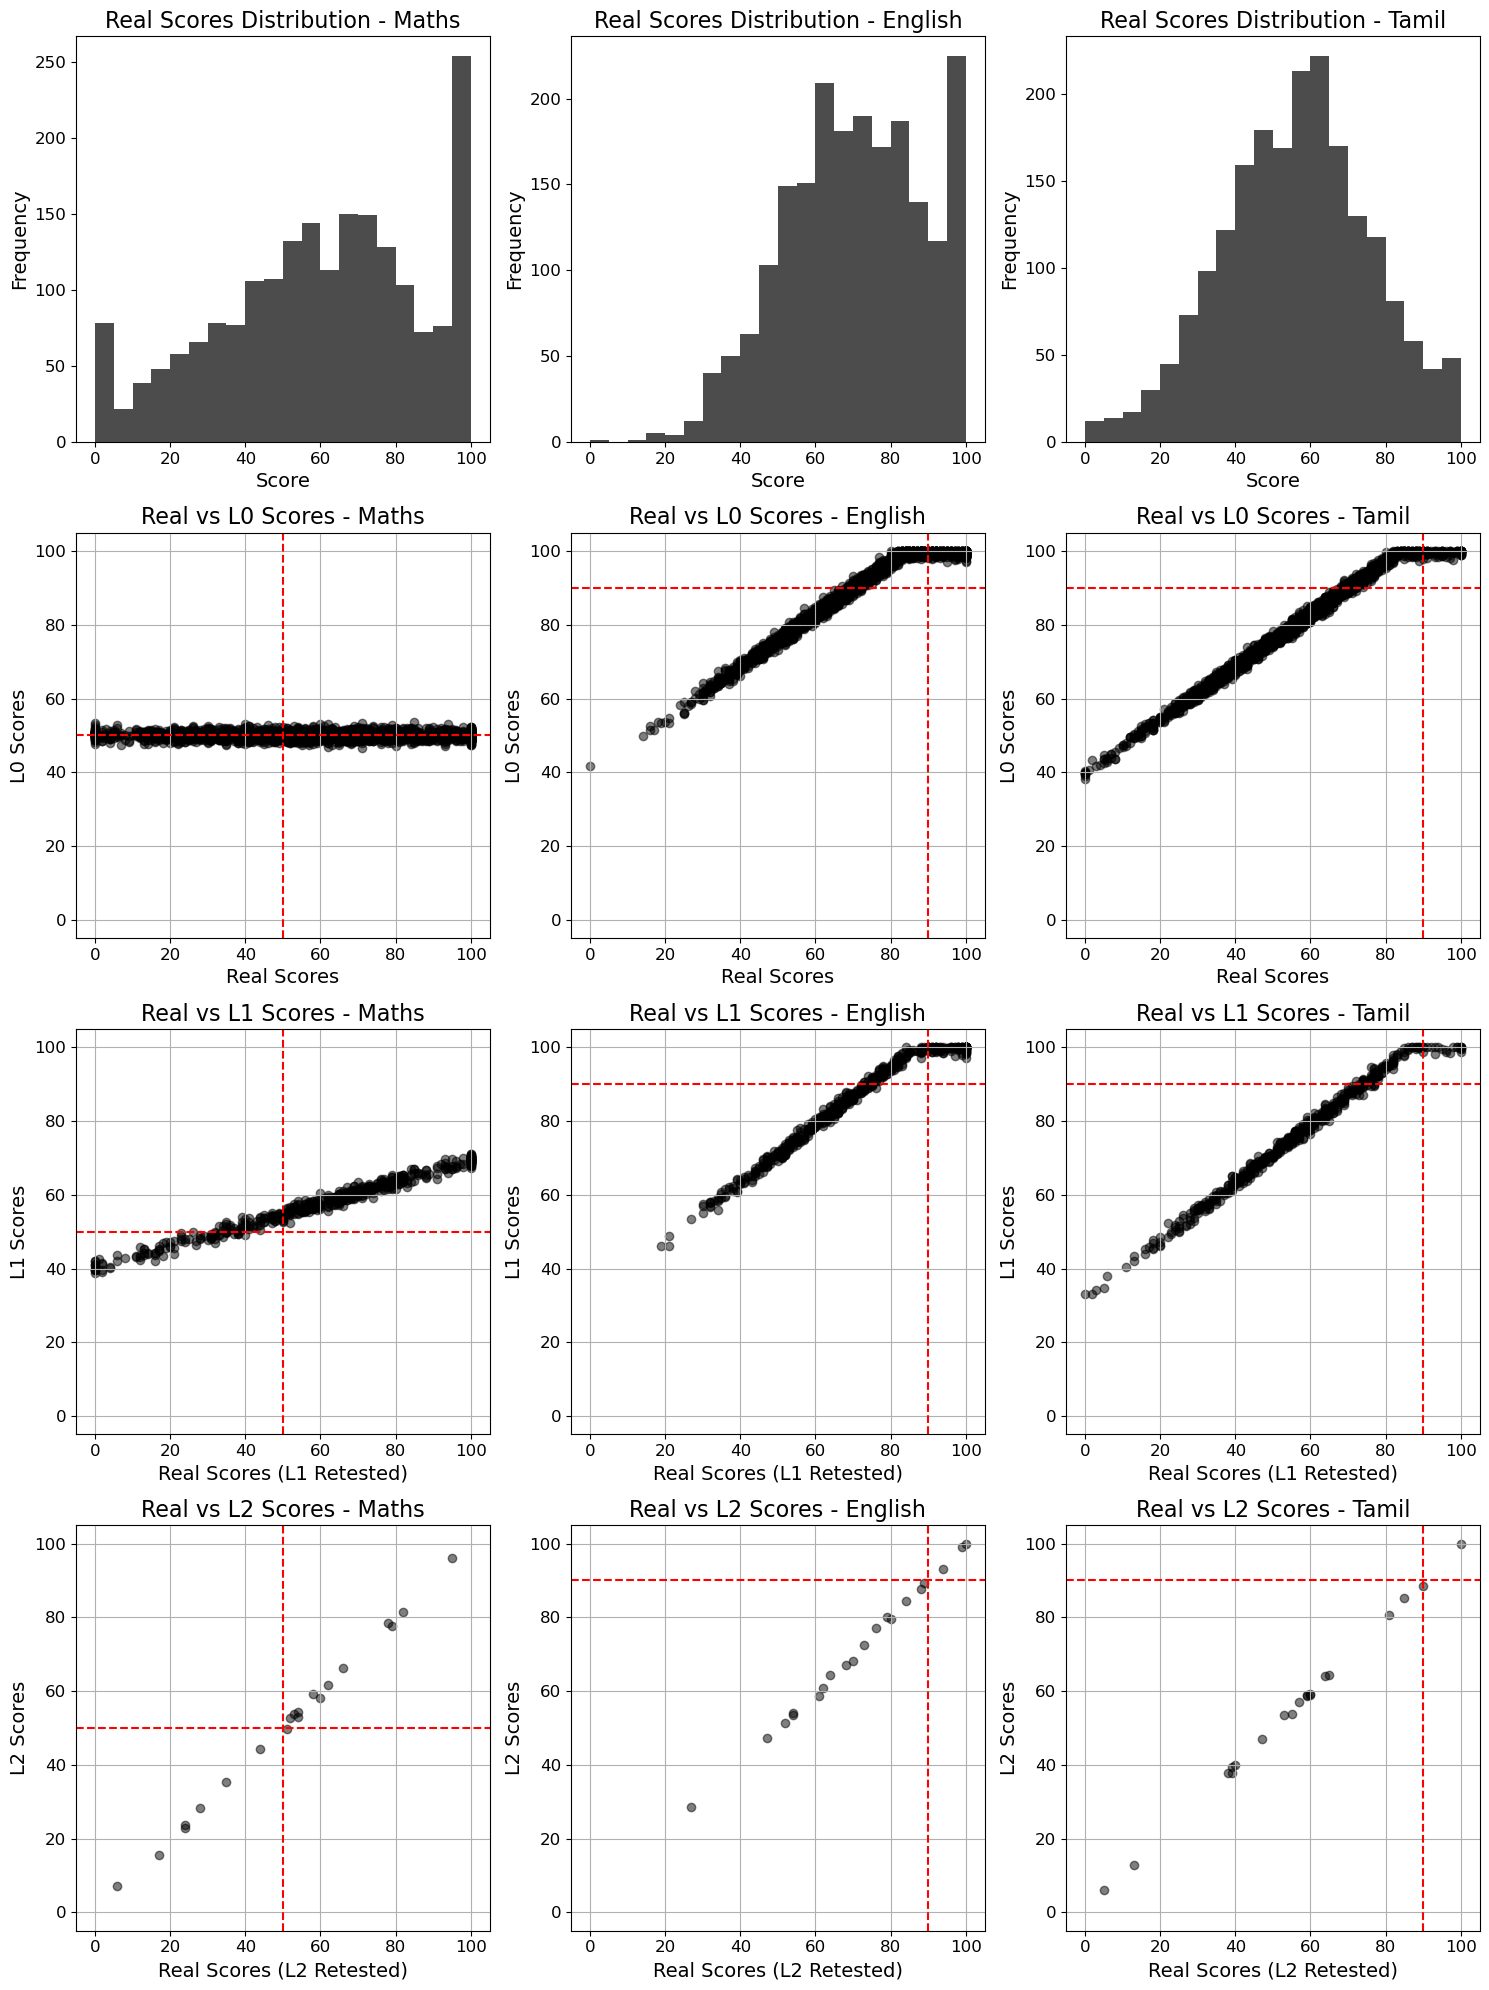

In [4]:
nested_scores = nested_simulation_functions.simulate_test_scores(
    students_per_school, 
    subjects_params, 
    passing_marks, 
    minimum_marks,
    delta,
    n_schools_per_L1, 
    n_L1s_per_L2, 
    n_L2s, 
    L1_retest_percentage, 
    L2_retest_percentage_schools, 
    L2_retest_percentage_students, 
    collusion_index, 
    moderation_index_L1 = moderation_index_L1, 
    moderation_index_L2 = moderation_index_L2, 
    measurement_error_mean = measurement_error_mean, 
    measurement_error_std_dev = measurement_error_std_dev,
)

nested_simulation_functions.plot_nested_scores(nested_scores, subjects, passing_marks)

# Discrepancy scores

## Non-binary (using all information)

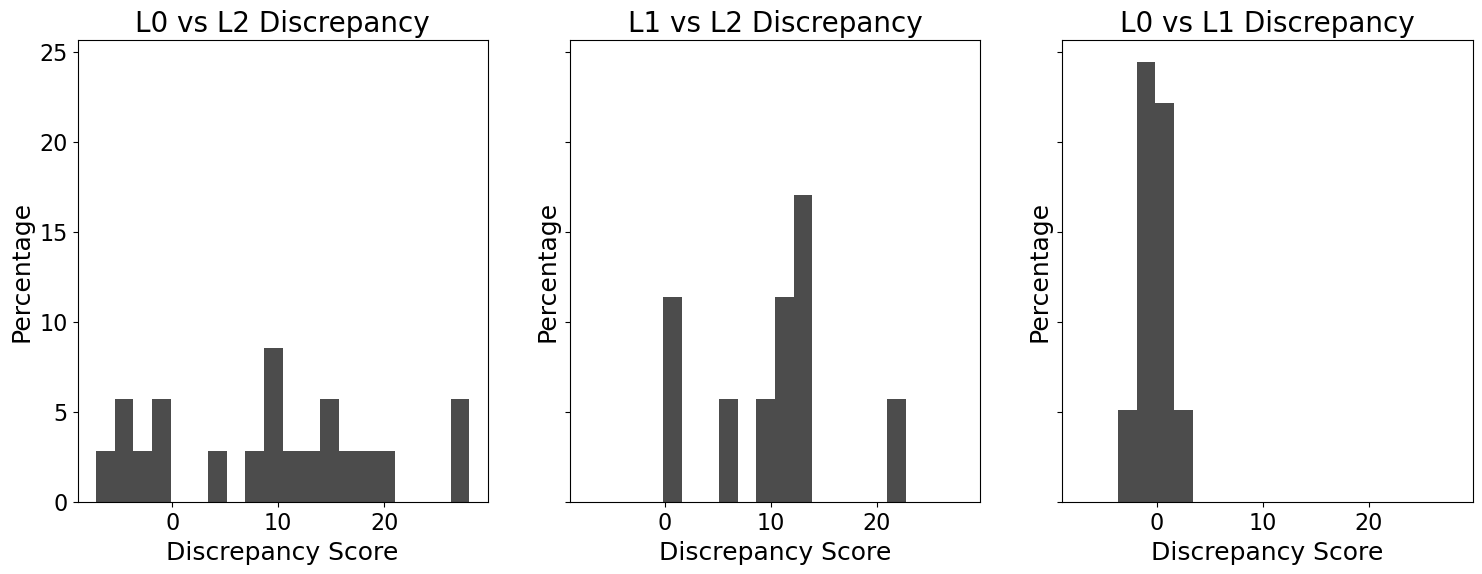

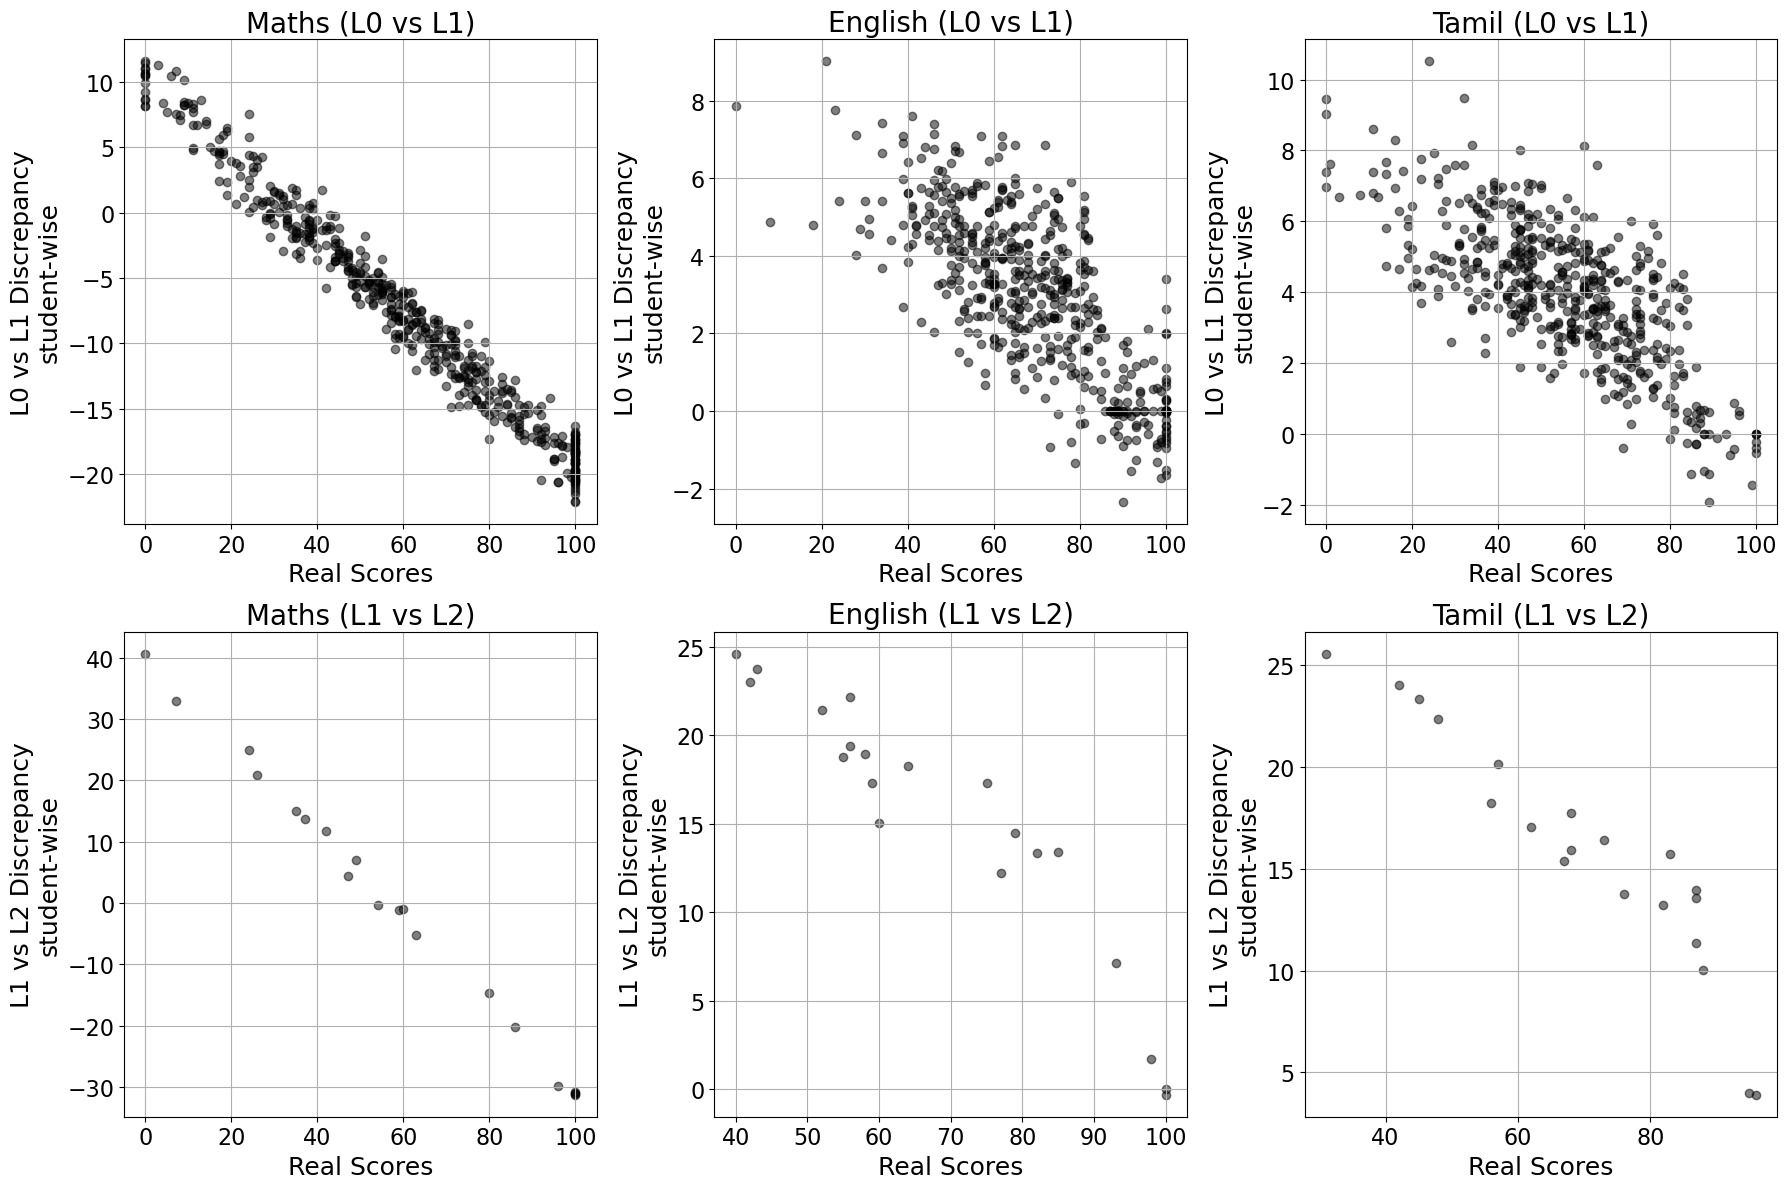

In [89]:
# Note: Type of discrepancy calculation (second parameter) can be: 
# 'simple_difference', 
# 'percent_difference', 
# 'absolute_difference', 
# 'absolute_percent_difference', 
# 'percent_non_match' (binary),
# 'directional_percent_non_match' (binary and only counts discrepancy when subordinate fails and supervisor passes),
# 'directional_difference' (only counts discrepancy when subordinate marks are higher than supervisor)

results = nested_simulation_functions.calculate_disc_scores(nested_scores, # Generated in cell 7
                                                            'simple_difference', # discrepancy calculation method - see note
                                                           passing_marks, # Defined in cell 2
                                                            subjects,
                                                           ) 

## Binary (pass-fail mismatch)

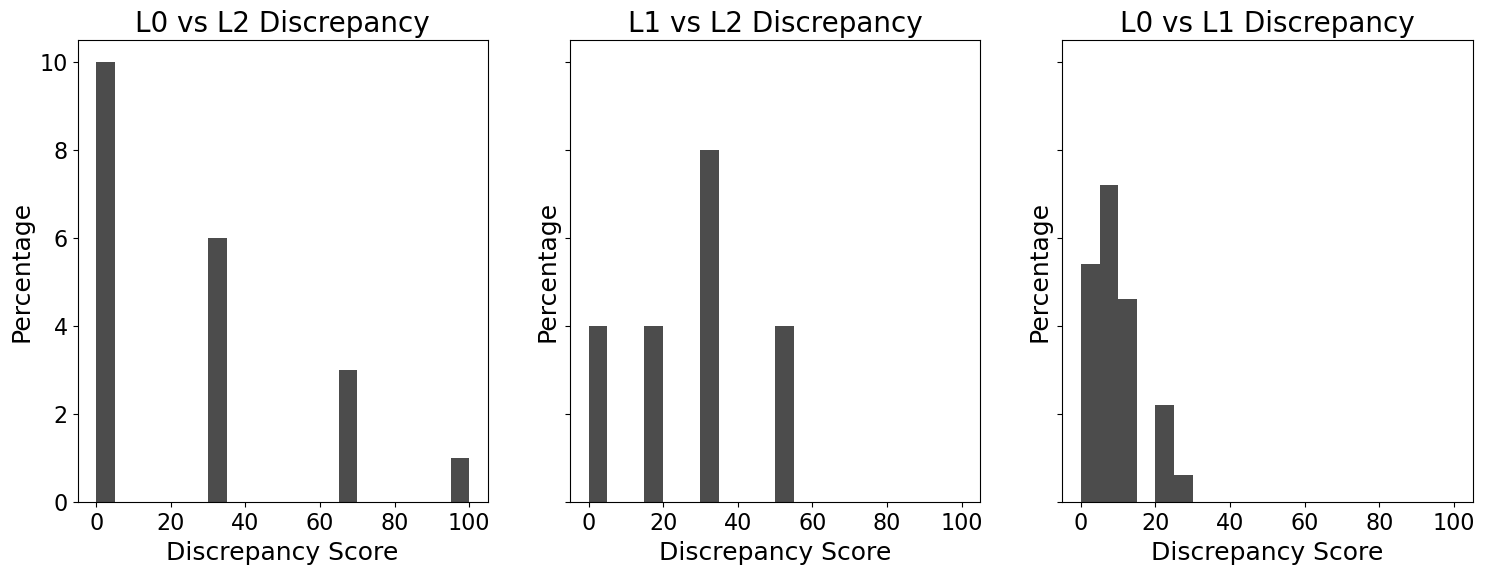

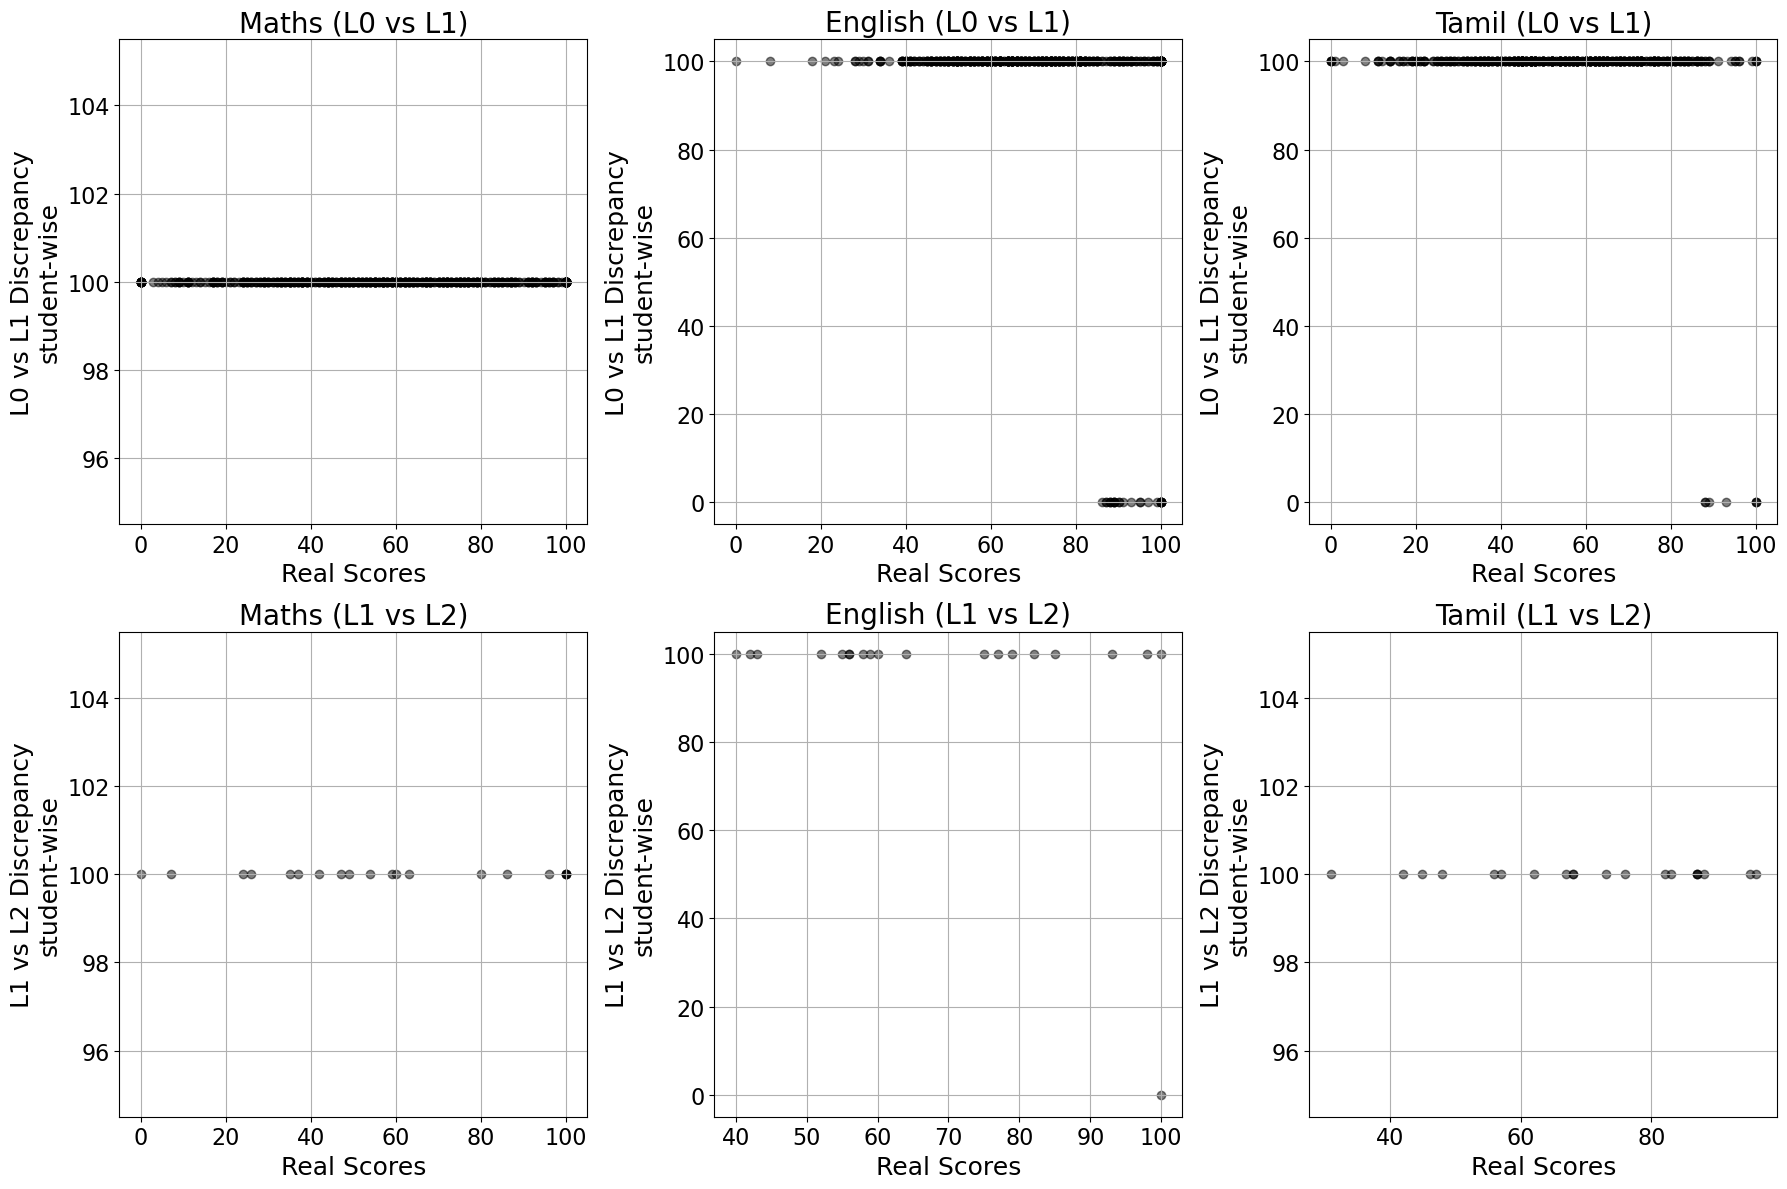

In [91]:
results = nested_simulation_functions.calculate_disc_scores(nested_scores, 'directional_percent_non_match',
                                                           passing_marks, subjects)

# Confidence guarantees

## Number of 'real' L0s in green zone, for a single L1

Structure of the generated dictionary nested_scores is as follows:

L2 ID -> L1 ID -> School ID (equivalent to L0 ID) -> 

        -> real scores -> student ID -> subject
        -> L0 scores -> student ID -> subject
        -> L1 scores -> student ID [may not exist for all students] -> subject
        -> L2 scores [may not exist for all schools] -> student ID [may not exist for all students] -> subject

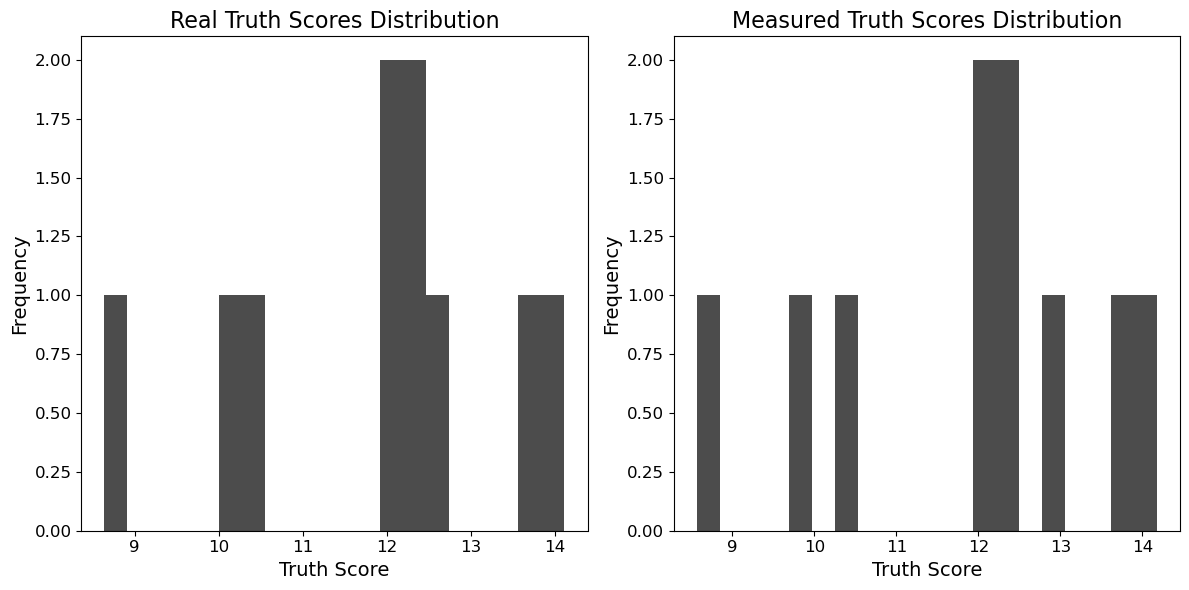

Number of true L0s = 2.96 out of 3
CIs = (2.9209215643219726, 2.9990784356780273)
L2-L1 truth score = -0.004168299234692606


In [37]:
n_simulations = 100
method = 'simple_difference'
n_L0s_reward = 3

(mean, cis, L2_L1_truth_score) = nested_simulation_functions.get_high_scoring_L0s(
    students_per_school,
    subjects_params,
    passing_marks,
    minimum_marks,
    delta,
    n_schools_per_L1,
    collusion_index,
    measurement_error_mean,
    measurement_error_std_dev,
    moderation_index_L1,
    method,
    n_L0s_reward,
    n_simulations
)

print('Number of true L0s = {0} out of {1}'.format(mean, n_L0s_reward))
print('CIs = {0}'.format(cis))
print('L2-L1 truth score = {0}'.format(L2_L1_truth_score))

## L1 confidence versus L2-L1 truth score

Simulating with L1 collusion index: 0.0
Simulating with L1 collusion index: 0.1
Simulating with L1 collusion index: 0.2
Simulating with L1 collusion index: 0.30000000000000004
Simulating with L1 collusion index: 0.4
Simulating with L1 collusion index: 0.5
Simulating with L1 collusion index: 0.6000000000000001
Simulating with L1 collusion index: 0.7000000000000001
Simulating with L1 collusion index: 0.8
Simulating with L1 collusion index: 0.9
Simulating with L1 collusion index: 1.0


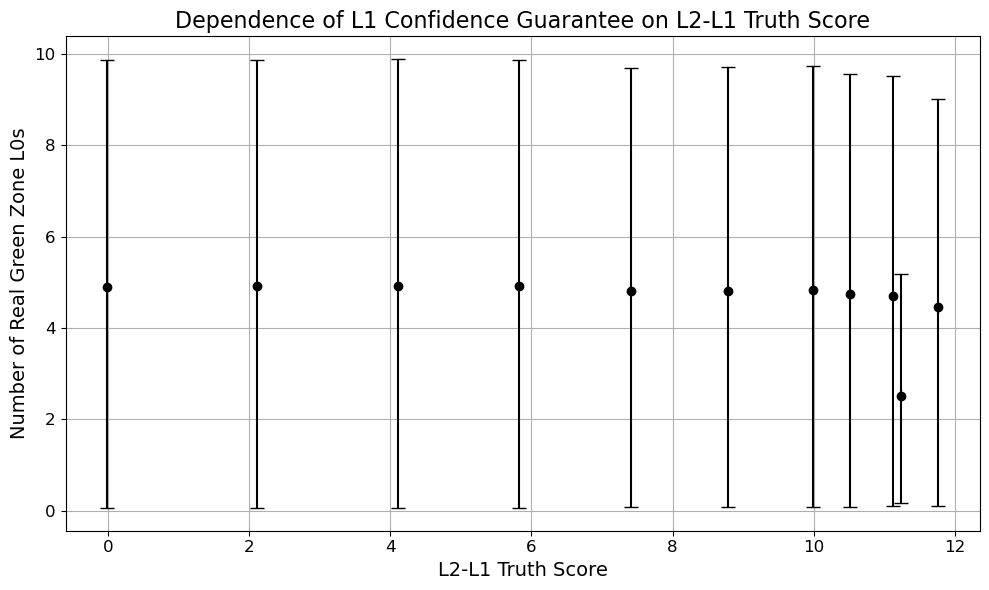

In [47]:
n_schools_per_L1 = 10
n_L0s_reward = 5
L1_collusion_index_list = np.linspace(0, 1, 11)

(n_real_L0s_mean, n_real_L0s_ci, L2_L1_truth_scores) = nested_simulation_functions.L1_reliability(L1_collusion_index_list, 
                   students_per_school,
    subjects_params,
    passing_marks,
    minimum_marks,
    delta,
    n_schools_per_L1,
    measurement_error_mean,
    measurement_error_std_dev,
    moderation_index_L1,
    method,
    n_L0s_reward,
    n_simulations)

In [45]:
L2_L1_truth_scores

[-0.0010829845265228144,
 6.308764882524489,
 10.569188339155914,
 10.900131930459395]

In [ ]:
figsize=(8, 11)
x_label_fontsize=14
y_label_fontsize=14
linecolor='k'
markerstyle='o'
elinewidth=0.5
errorbar_capsize=2
legend_fontsize=14

# Create figure and axis handles
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=figsize)


# Plot mean and error bars of number of real green zone units
ax1.errorbar(L2_L1_truth_scores, mean_n_real, errorbars_n_real, 
            color=linecolor, marker=markerstyle, elinewidth=elinewidth, 
            capsize=errorbar_capsize)

# Plot dashed line to show the maximum possible number of real green zone units
ax1.plot(list_n_sub, np.ones(len(list_n_sub))*n_blocks_plot, color='b', linestyle='--', 
         linewidth=1.5, label='Number of units rewarded (b)')
ax1.legend(fontsize=legend_fontsize, title=f'Errorbars: {errorbar_type}')

# Set up the primary x-axis (number of L0s per unit)
ax1.set_xticks(list_n_sub)
ax1.set_xlim(list_n_sub[0] - 0.5, list_n_sub[-1]*1.1)
ax1.set_xlabel('Number of L0s tested per unit (m)', fontsize=x_label_fontsize)

# Create a divider for the primary x-axis to append a new x-axis below
divider = make_axes_locatable(ax1)
ax2 = divider.append_axes("bottom", size="5%", pad=0.7)

# Hide the new x-axis' frame
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Set the ticks and tick labels for the secondary x-axis
ax2.set_xticks(list_n_sub)
ax2.set_xticklabels(list_n_samples)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel('Number of samples per L0 (n)', fontsize=x_label_fontsize)

# Hide the y-axis for the secondary x-axis
ax2.yaxis.set_visible(False)
ax1.set_ylim([0, n_blocks_plot + 1])

ax1.set_ylabel("Number of 'real' best units found (c)", fontsize=y_label_fontsize)

# Chart title
ax1.set_title('This chart shows the expected outcome when {0} out of {1} top-scoring units\nare selected for reward, using a variety of sampling strategies.\nThe sampling strategy is indicated on the X-axis in terms of the number of L0s\nin each unit tested by a supervisor, and the number of samples tested per L0.\nThe solid black line shows how many of the {0} top-scoring units are expected to be\n\'real\' top-scoring units. For example, if {2} L0s are tested per unit\nand {3} samples per L0, then we can be confident that\naround {4} of the {0} rewarded units were deserving of the reward.\nThe dashed blue line shows the number of rewarded units.\n'.format(
    n_blocks_plot, 
    n_blocks, 
    list_n_sub[0], 
    list_n_samples[0], 
    np.round(mean_n_real[0], 1)
    ),
    fontsize=10
)
fig.tight_layout(pad=1.0)